<a href="https://colab.research.google.com/github/periwinklemctartins/Coronavirus--Propogation-Simulation/blob/master/~Saskatchewan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib           
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

#Connections between Canadian Provinces
A = torch.tensor([[1,     1,     1,     0,     0,     0,     0,     0,     1,     0,     1,     1,     1],
                  [1,     1,     1,     0,     0,     1,     0,     0,     1,     0,     1,     1,     0],
                  [1,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     0],
                  [0,     0,     0,     1,     1,     0,     0,     0,     1,     1,     1,     0,     0],
                  [0,     0,     0,     1,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [0,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     1],
                  [0,     0,     0,     0,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [0,     0,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     1],
                  [1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
                  [0,     0,     0,     1,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
                  [1,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     0],
                  [1,     0,     0,     0,     0,     1,     0,     1,     1,     0,     1,     0,     1]]);

#Number of connections each province has                  
L = torch.tensor([[6,    -1,    -1,     0,     0,     0,     0,     0,    -1,     0,    -1,    -1,    -1], 
                  [-1,    6,    -1,     0,     0,    -1,     0,     0,    -1,     0,    -1,    -1,     0],
                  [-1,    1,     7,     0,     0,    -1,     0,    -1,    -1,     0,    -1,    -1,     0],
                  [0,     0,     0,     4,    -1,     0,     0,     0,    -1,    -1,    -1,     0,     0],
                  [0,     0,     0,    -1,     5,     0,    -1,     0,    -1,    -1,    -1,     0,     0],
                  [0,    -1,    -1,     0,     0,     7,     0,    -1,    -1,     0,    -1,    -1,    -1],
                  [0,     0,     0,     0,    -1,     0,     4,     0,    -1,    -1,    -1,     0,     0],
                  [0,     0,    -1,     0,     0,    -1,     0,     6,    -1,     0,    -1,    -1,    -1],
                  [-1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    12,    -1,    -1,    -1,   -1],
                  [0,     0,     0,    -1,    -1,     0,    -1,     0,    -1,     5,    -1,     0,     0],
                  [-1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    12,    -1,   -1],
                  [-1,    -1,    -1,     0,     0,    -1,     0,    -1,    -1,     0,    -1,     7,    0],
                  [-1,     0,     0,     0,     0,    -1,     0,    -1,    -1,     0,    -1,     0,    5]]);



In [0]:
def SEImodel(theta,S,E,I):
    alpha = theta[0]
    beta  = theta[1]
    gamma = theta[2]
    mu    = theta[3]
    kE    = theta[4]
    kS    = theta[5]
    kI    = theta[6]
    

    dSdt  = -kS*L[n,n]*S - beta*E*S - gamma*I*S                 # dS/dt
    dEdt  = -kE*L[n,n]*E + beta*E*S  + gamma*I*S - alpha*E      # dE/dt
    dIdt  = -kI*L[n,n]*I + alpha*E - mu*I                       # dI/dt
    
    return dSdt, dEdt, dIdt




In [0]:
def integrateSEI(theta,S0,E0,I0,dt,nt):
    
    # vectors to save the results over time
    Sout = torch.zeros(nt+1); Sout[0] = S0
    Eout = torch.zeros(nt+1); Eout[0] = E0
    Iout = torch.zeros(nt+1); Iout[0] = I0
    
    S = S0; E = E0; I = I0
    for i in range(nt):
        dSdt, dEdt, dIdt = SEImodel(theta,S,E,I)
 

        S += dt*dSdt
        E += dt*dEdt
        I += dt*dIdt

        Sout[i+1] = S
        Eout[i+1] = E
        Iout[i+1] = I
       
    if I >= 0.05:
      print(S,E,I)
      return Sout, Eout, Iout
       
    return Sout, Eout, Iout
    


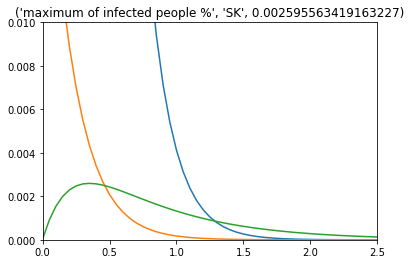

In [21]:
#SK Data as of March 22 2020
PopulationSK = 1174000  #Census Canada
Recovered = 0          #Deceased -> it is impossible to tell if people who have recovered have returned to being infected
Infected = 33 - Recovered    #https://www150.statcan.gc.ca/n1/daily-quotidien/200428/dq200428a-eng.htm
Succeptible = PopulationSK - Infected
#Exposed -> true value is unknown -> assume 15% of those who are exposed are not sick

xmin = 0; xmax = 2.5;
ymin = 0; ymax = .01;

#March 28th highest amount of new infected, good data can be found here https://www.saskatchewan.ca/government/health-care-administration-and-provider-resources/treatment-procedures-and-guidelines/emerging-public-health-issues/2019-novel-coronavirus/cases-and-risk-of-covid-19-in-saskatchewan

S0 = Succeptible/PopulationSK
E0 = 0.022
I0 = Infected/PopulationSK

# Set the duration for the simulation
dt = 0.05; nt = 50

# We pick the parameters as follows
alpha = .8       #rate of exposed people that get sick
beta  = .5       #rate of interaction of exposed and susceptible
gamma = .1       #rate of interaction infected and susceptible
mu    = 0.015       #rate of pepole who get resistence or die
kE    = 0.6       #Exposed people that move around
kS    = 0.8       #Susceptible people that move around
kI    = 0.25     #Sick people that move around (Diffusion of sick people)
theta = torch.tensor([alpha, beta, gamma, mu, kE, kS, kI])

P = ['AB', 'BC', 'MB', 'NB', 'NL', 'NT', 'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']
for n in range(1):

  S, E, I = integrateSEI(theta,S0,E0,I0,dt,nt)

  t = np.arange(nt+1)*dt
  title = 'maximum of infected people % on a given day', P[11], torch.max(I).item()
  plt.figure(11)
  plt.title(title)
  plt.plot(t,S,t,E,t,I)

  axes = plt.gca()
  axes.set_xlim([xmin,xmax])
  axes.set_ylim([ymin,ymax])


In [0]:
#def ChemReacTime(beta,gamma,S0,E0,I0,dt,nt):  #Looks to be similar to integrateSEI
#    
#    A = torch.zeros(nt+1); B = torch.zeros(nt+1)
#    S[0] = S0; E[0] = E0; I[0] = I0
#    for i in range(nt):
#        F = ChemReac(alpha,beta,gamma,S[i],E[i],I[i])
#        S[i+1] = S[i] + dt*F[0]
#        E[i+1] = E[i] + dt*F[1]
#        I[i+1] = I[i] + dt*F[2]
#        
#    return S, E, I

In [0]:
#def ChemReac(alpha,beta,gamma,A,B):  #Looks to be similar to SEImodel
#    
#    F = torch.zeros(3)
#    F[0]  = -kS*L[n,n]*S - beta*E*S - gamma*I*S                 # dS/dt
#    F[1]  = -kE*L[n,n]*E + beta*E*S  + gamma*I*S - alpha*E      # dE/dt
#    F[2]  = -kI*L[n,n]*I + alpha*E - mu*I                       # dI/dt
#    
#    return F

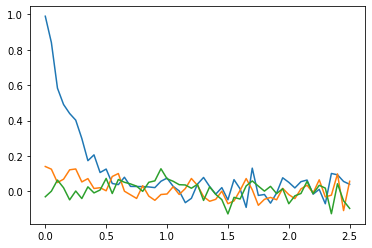

In [0]:
t = np.arange(nt+1); t = t*dt

# Add noise to the data
ndata = S.shape
nS = torch.randn(ndata[0])*0.05
nE = torch.randn(ndata[0])*0.05
nI = torch.randn(ndata[0])*0.05

Sobs = S+nS; Eobs = E+nE; Iobs = I+nI  #observed plus noise

# This is what we observe
plt.plot(t,Sobs) #make noise smaller to make the curves nicer
plt.plot(t,Eobs)
plt.plot(t,Iobs) 


In [0]:
def loss(alpha,beta,gamma,Sobs,Eobs,Iobs,nt,dt):
    
    Scomp, Ecomp, Icomp = integrateSEI(theta,S0,E0,I0,dt,nt) #comp is computed from code with a chosen beta, gamma 
    phi = torch.sum((Scomp-Sobs)**2) + torch.sum((Ecomp-Eobs)**2) + torch.sum((Icomp-Iobs)**2) #if comp and obs is the same then phi goes to zero
    
    return phi


tensor(0.3538)


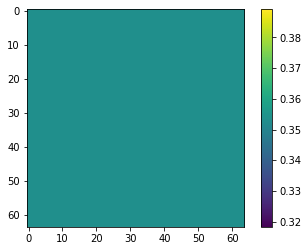

In [0]:
Phi = torch.zeros(64,64)
b = np.arange(64)/64.0; g = np.arange(64)/16.0; h = np.arange(64)/4.0;
for i in range(64):
    for j in range(64):
      for k in range(64):
        t = loss(b[i],g[j],h[k],Sobs,Eobs,Iobs,nt,dt)        
        Phi[i,j] = t
print(loss(alpha,beta,gamma,Sobs,Eobs,Iobs,nt,dt))       
plt.imshow(Phi)
plt.colorbar()

In [0]:
def SumOfSquares(x):
    return 0.5*torch.sum(x**2)

In [0]:
# Now we compute gradients
x = torch.tensor(S, requires_grad=True)
SofSquares = SumOfSquares(x)


# Differentiate S, the gradient with respect to S is stored in S
SofSquares.backward()
grady = x.grad

print(grady)


tensor([9.9996e-01, 8.1742e-01, 6.6851e-01, 5.4694e-01, 4.4762e-01, 3.6645e-01,
        3.0007e-01, 2.4577e-01, 2.0133e-01, 1.6494e-01, 1.3516e-01, 1.1076e-01,
        9.0773e-02, 7.4400e-02, 6.0984e-02, 4.9990e-02, 4.0980e-02, 3.3595e-02,
        2.7542e-02, 2.2580e-02, 1.8513e-02, 1.5178e-02, 1.2445e-02, 1.0204e-02,
        8.3662e-03, 6.8597e-03, 5.6246e-03, 4.6119e-03, 3.7815e-03, 3.1007e-03,
        2.5425e-03, 2.0848e-03, 1.7095e-03, 1.4017e-03, 1.1494e-03, 9.4247e-04,
        7.7281e-04, 6.3369e-04, 5.1962e-04, 4.2608e-04, 3.4939e-04, 2.8649e-04,
        2.3492e-04, 1.9263e-04, 1.5796e-04, 1.2953e-04, 1.0621e-04, 8.7092e-05,
        7.1415e-05, 5.8560e-05, 4.8019e-05])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [0]:
# Now we compute gradients
x = torch.tensor(E, requires_grad=True)
EofSquares = SumOfSquares(x)


# Differentiate E, the gradient with respect to E is stored in E
EofSquares.backward()
grady = x.grad

print(grady)

tensor([1.7000e-01, 1.4110e-01, 1.1678e-01, 9.6412e-02, 7.9439e-02, 6.5343e-02,
        5.3673e-02, 4.4035e-02, 3.6092e-02, 2.9557e-02, 2.4188e-02, 1.9783e-02,
        1.6172e-02, 1.3214e-02, 1.0793e-02, 8.8135e-03, 7.1949e-03, 5.8722e-03,
        4.7918e-03, 3.9095e-03, 3.1892e-03, 2.6014e-03, 2.1216e-03, 1.7302e-03,
        1.4109e-03, 1.1504e-03, 9.3797e-04, 7.6473e-04, 6.2345e-04, 5.0826e-04,
        4.1433e-04, 3.3776e-04, 2.7533e-04, 2.2443e-04, 1.8294e-04, 1.4911e-04,
        1.2154e-04, 9.9067e-05, 8.0748e-05, 6.5815e-05, 5.3643e-05, 4.3722e-05,
        3.5635e-05, 2.9044e-05, 2.3672e-05, 1.9294e-05, 1.5725e-05, 1.2816e-05,
        1.0446e-05, 8.5133e-06, 6.9385e-06])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [0]:
# Now we compute gradients
x = torch.tensor(I, requires_grad=True)
IofSquares = SumOfSquares(x)


# Differentiate I, the gradient with respect to I is stored in I
IofSquares.backward()
grady = x.grad

print(grady)

tensor([3.6136e-05, 5.9821e-03, 1.0252e-02, 1.3194e-02, 1.5094e-02, 1.6187e-02,
        1.6665e-02, 1.6682e-02, 1.6359e-02, 1.5794e-02, 1.5063e-02, 1.4227e-02,
        1.3329e-02, 1.2406e-02, 1.1482e-02, 1.0576e-02, 9.7030e-03, 8.8705e-03,
        8.0848e-03, 7.3490e-03, 6.6646e-03, 6.0314e-03, 5.4485e-03, 4.9139e-03,
        4.4253e-03, 3.9802e-03, 3.5756e-03, 3.2089e-03, 2.8771e-03, 2.5774e-03,
        2.3071e-03, 2.0638e-03, 1.8450e-03, 1.6485e-03, 1.4721e-03, 1.3140e-03,
        1.1724e-03, 1.0456e-03, 9.3224e-04, 8.3089e-04, 7.4034e-04, 6.5948e-04,
        5.8732e-04, 5.2293e-04, 4.6551e-04, 4.1432e-04, 3.6869e-04, 3.2804e-04,
        2.9183e-04, 2.5959e-04, 2.3087e-04])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
